# Unbinned log likelihood fitting with nllfitter


This is an example of estimating model parameters of a probability distribution function by minimizing the negative log likelihood (nll).  This will be carried out on dataset that was generated to simulate the discovery of the Higgs boson in the diphoton decay channel.  This can all be run via the script (test/hgg_fit.py).  Let's first import all the necessary modules:

In [1]:
import numpy as np
from scipy.stats import norm
from lmfit import Parameters

from nllfitter import NLLFitter, Model
from nllfitter.fit_tools import get_data, fit_plot, scale_data
%matplotlib inline

Now we'll need get the data that we will be modelling.  Given that the Higgs boson is known to have a mass of 125 GeV, we will only consider datapoints lying between 100 and 180 GeV.  The get_data function will scale the data to lie in the range [-1, 1].  This is motivated by the fact that we will be using Legendre polynomials to model the background.

In [2]:
xlimits = (100., 180.)
data, n_total = get_data('../data/toy_hgammagamma.txt', 'diphoton_mass', xlimits)

Let's define the background pdf and background plus signal datasets.

In [3]:
def bg_pdf(x, a):
    '''
    Third order Legendre Polynomial with constant term set to 0.5.

    Parameters:
    ===========
    x: data
    a: model parameters (a1 and a2)
    '''
    return 0.5 + a[0]*x + 0.5*a[1]*(3*x**2 - 1) + 0.5*a[2]*(5*x**3 - 3*x)

def sig_pdf(x, a):
    '''
    Third order Legendre Polynomial (normalized to unity) plus a Gaussian.

    Parameters:
    ===========
    x: data
    a: model parameters (a1, a2, mu, and sigma)
    '''
    return (1 - a[0])*bg_pdf(x, a[3:6]) + a[0]*norm.pdf(x, a[1], a[2])


For the background model (null hypothesis) we will use a third order Legendre polynomial normalized to unity (this is satisfied by requiring the coefficient for the constand term be 0.5).  The background plus signal model (alternative model) will include an additional Gaussian term.  The mean of the Gaussian should correspond to the Higgs boson mass.

Let's set up the background only fit,

In [4]:
bg_params = Parameters()
bg_params.add_many(
                   ('a1', 0., True, None, None, None),
                   ('a2', 0., True, None, None, None),
                   ('a3', 0., True, None, None, None)
                  )

bg_model  = Model(bg_pdf, bg_params)
bg_fitter = NLLFitter(bg_model)

The NLLFitter framework uses the lmfit Parameters class.  The usage is described [here](https://lmfit.github.io/lmfit-py/parameters.html).  The Model class holds the functional form of the pdf and the parameters.  The NLLFitter is initialized with bg_model which will be used to fit to the data as follows, 

In [5]:
bg_result = bg_fitter.fit(data)

Fit finished with status: 0
[[Variables]]
    a1:  -0.48120178 +/- 0.007830 (1.63%) (init= 0)
    a2:   0.18260829 +/- 0.011468 (6.28%) (init= 0)
    a3:  -0.04508985 +/- 0.012017 (26.65%) (init= 0)

[[Correlation matrix]]
[[ 1.    -0.463  0.147]
 [-0.463  1.    -0.462]
 [ 0.147 -0.462  1.   ]] 



That's all there is to it.  (N.B. the parameters are correct for the range [-1, 1], but in general won't be for the true range.  This will be addressed in iterations in the near future).  Let's do the same for the background plus signal model,

In [6]:
sig_params = Parameters()
sig_params.add_many(
                    ('A'     , 0.01 , True , 0.   , 1.   , None),
                    ('mu'    , -0.3 , True , -0.8 , 0.8  , None),
                    ('sigma' , 0.01 , True , 0.01 , 1.   , None),
                   )
sig_params += bg_params.copy()
sig_model  = Model(sig_pdf, sig_params)
sig_fitter = NLLFitter(sig_model)
sig_result = sig_fitter.fit(data)

Fit finished with status: 0
[[Variables]]
    A:       0.02673810 +/- 0.006351 (23.76%) (init= 0.01)
    mu:     -0.36592351 +/- 0.015114 (4.13%) (init=-0.3)
    sigma:   0.06514098 +/- 0.014425 (22.14%) (init= 0.01)
    a1:     -0.47894778 +/- 0.008085 (1.69%) (init= 0)
    a2:      0.20645574 +/- 0.012726 (6.16%) (init= 0)
    a3:     -0.08015350 +/- 0.014607 (18.22%) (init= 0)

[[Correlation matrix]]
[[ 1.    -0.344  0.67   0.102  0.385 -0.526]
 [-0.344  1.    -0.467 -0.107 -0.042  0.148]
 [ 0.67  -0.467  1.     0.091  0.243 -0.353]
 [ 0.102 -0.107  0.091  1.    -0.381  0.046]
 [ 0.385 -0.042  0.243 -0.381  1.    -0.582]
 [-0.526  0.148 -0.353  0.046 -0.582  1.   ]] 



Note that I was able to just add a copy of the background parameters to the signal parameters.  Be careful to pass a copy, though, or otherwise the values in bg_params will be different after carrying out the fit of sig_model to the data.  Let's see how our fits look,

/home/naodell/intel/intelpython27/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


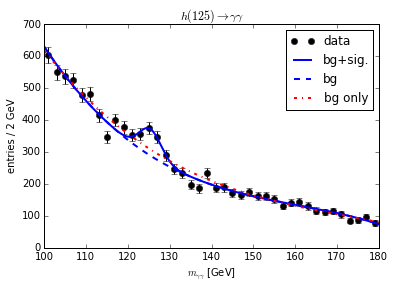

In [7]:
fit_plot(data, xlimits, sig_model, bg_model, 'hgg', show=True)

Thats' a damn fine fit there.  By eye it looks pretty clear that the background plus signal fits to the data better.  The standard figure of merit for quantizing this model comparison is the likelihood ratio vis-a-vis Wilk's theorem,

In [10]:
q = 2*(bg_model.calc_nll(data) - sig_model.calc_nll(data))
print 'z = {0}'.format(np.sqrt(q))

z = 5.86698539059


Given the pseudodata was generated by injecting $\sim 5\sigma$ signal, this result is to be expected.